# Motivation:

For my CSCI capstone project I am collaborating to develop a moible application that employes computer vision to preform object detection and ideally segmentation on ultrasound images. The objective is to help people in medically disparaged places use the powerful but difficult technology. Some of the limitations imposed on this project were the lack of readily availible electricity and modern computing hardware. Because of this our scope for model complexity is limited to reserve enery draw on phones.

Deep covolutional neural networks, like we have chosen to employ, trade sphicsticated results for large computation time and lack of interpretability. While other methods of statistical analysis or machine learning would struggle to capsture the complexity of the data and underfit they have appeal because of their preformant nature. 


## Problems I will be trying to solve

For my final project I will be preforming a exporatory analysis on a dataset of ultrasound images with two goals in mind(along with their relevant sub-goals):
1. Classify images using non-neural network approaches
	1. Classify images based on the body part being scanned
	2. Classify images as quality scans
2. Search for statistical methods to help assist neural networks classification accuracy
	1. Detect features such as scan depth, general scan quality
	2. Preforming pre-processing on scans
	3. Find correlations between general image features and scan types
	4. Detect anomalies such as a incorrectly preformed scan

# Imports and notebook setup

We will be using industry standard data analsis and machine learning tools to do our exploration. 

## Install and import libraries

In [1]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2
import urllib.request
from tqdm import tqdm
from IPython.display import display, Markdown, Latex, Image

## Dataset Construction

### Setting up file names

In [3]:
training_uri = './data/training1.pkl'
testing_uri = './data/testing.pkl'

### Downloading Dataset

In [4]:
if not os.path.exists('./data/'):
    LARGE_DATASET_URLS = [
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_test.tar.gz',
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_training1.tar.gz',
        'https://github.com/ButterflyNetwork/MITGrandHack2018/releases/download'
        '/v.0.0.1/butterfly_dataset_training2.tar.gz',
    ]
    ! mkdir data
    class ProgressDownload(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
    for url in LARGE_DATASET_URLS:
        with ProgressDownload(unit='B', unit_scale=True, miniters=1, desc=url) as progress_bar:
            urllib.request.urlretrieve(url, filename='temp.tar.gz', reporthook=progress_bar.update_to)
            ! tar -xzf temp.tar.gz -C data/
            ! rm -f temp.tar.gz

### Exploring Dataset Structure

In [5]:
!tree -L 4 data/test | head

data/test
├── 26
│   ├── 2ch
│   │   ├── 000.png
│   │   ├── 001.png
│   │   ├── 002.png
│   │   ├── 003.png
│   │   ├── 004.png
│   │   ├── 005.png
│   │   ├── 006.png


### Unpacking Labels

In [6]:
labels = set()
for label in os.listdir('./data/training1/1/'):
    if os.path.isdir(os.path.join('./data/training1/1', label)):
        labels.add(label)
labels = list(labels)
display(labels)

['thyroid',
 'ivc',
 'bladder',
 'morisons_pouch',
 '2ch',
 'lungs',
 '4ch',
 'carotid',
 'plax']

### Constructing Data Frames

In [7]:
df = None
if not os.path.exists(training_uri):
    df = [['Label', 'Patient', 'Image']]
    for patient in os.listdir('./data/training1/'):
        local_path = os.path.join('./data/training1/', patient)
        if os.path.isdir(local_path):
            for location in os.listdir(local_path):
                sub_local_path = os.path.join(local_path, location)
                if os.path.isdir(sub_local_path):
                    for video in os.listdir(sub_local_path):
                        image = cv2.imread(os.path.join(sub_local_path, video), cv2.IMREAD_GRAYSCALE)
                        if(type(image) == np.ndarray):
                            df.append([location, patient, image])
    df = pd.DataFrame(df[1:], columns=df[0])
else:
    df = pd.read_pickle(training_uri)
len(df.index)

3510

In [8]:
df_test = None
if not os.path.exists(testing_uri):
    df_test = [['Label', 'Patient', 'Image']]
    for patient in os.listdir('./data/test/'):
        local_path = os.path.join('./data/test/', patient)
        if os.path.isdir(local_path):
            for location in os.listdir(local_path):
                sub_local_path = os.path.join(local_path, location)
                if os.path.isdir(sub_local_path):
                    for video in os.listdir(sub_local_path):
                        image = cv2.imread(os.path.join(sub_local_path, video), cv2.IMREAD_GRAYSCALE)
                        if(type(image) == np.ndarray):
                            df_test.append([location, patient, image])
    df_test = pd.DataFrame(df_test[1:], columns=df_test[0])
else:
    df_test = pd.read_pickle(testing_uri)

### Shrinking dataset size

In [9]:
if not os.path.exists(training_uri):
    df = df.groupby(['Label', 'Patient'], group_keys=False).apply(lambda x: x.sample(30))
if not os.path.exists(testing_uri):
    df_test = df_test.groupby(['Label', 'Patient'], group_keys=False).apply(lambda x: x.sample(10))

### Preprocessing Image

In [10]:
if not os.path.exists(training_uri):
    df["Patient"] = pd.to_numeric(df["Patient"])
if not os.path.exists(testing_uri):
    df_test["Patient"] = pd.to_numeric(df_test["Patient"])

### Writing processed datasets

In [11]:
if not os.path.exists(training_uri):
    df.to_pickle(training_uri)
if not os.path.exists(testing_uri):
    df_test.to_pickle(testing_uri)

# Data Exporation

## Interpreting Data Objects

### General

In [12]:
display(Markdown("#### General Data Information"))
display(df.info())
display(Markdown('#### I\'m not printing a detailed description because it would take forever to run over our images'))

#### General Data Information

<class 'pandas.core.frame.DataFrame'>
Index: 3510 entries, 14032 to 18798
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    3510 non-null   object
 1   Patient  3510 non-null   int64 
 2   Image    3510 non-null   object
dtypes: int64(1), object(2)
memory usage: 109.7+ KB


None

#### I'm not printing a detailed description because it would take forever to run over our images

In [13]:
df.head()

,Label,Patient,Image
14032,2ch,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
14050,2ch,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
14123,2ch,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
14061,2ch,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
14128,2ch,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Labels

#### General Information

count     3510
unique       9
top        2ch
freq       390
Name: Label, dtype: object

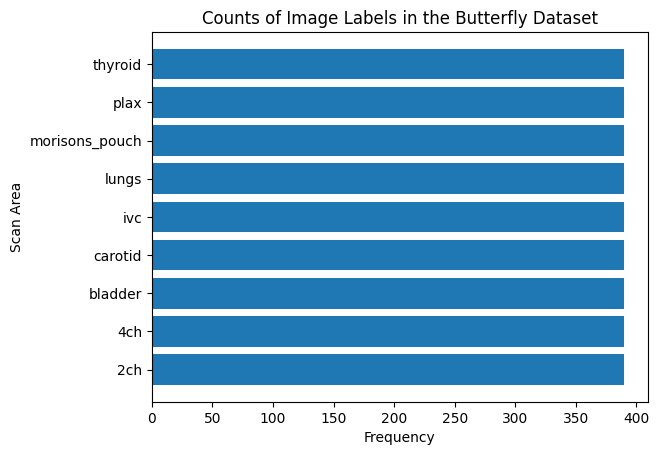

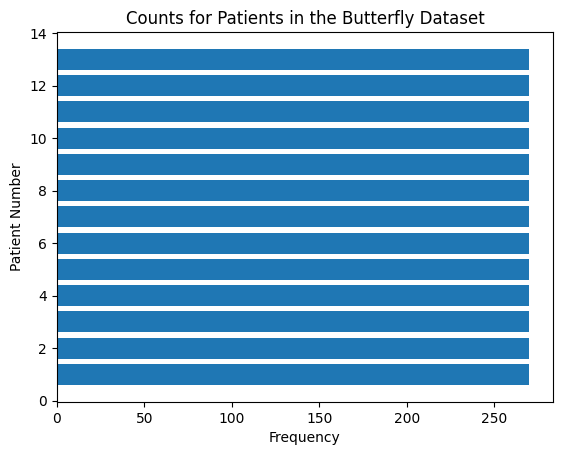

In [14]:
display(Markdown("#### General Information"))
display(df["Label"].describe())

label_counts = df['Label'].value_counts()
plt.barh(label_counts.index, label_counts.values)
plt.ylabel('Scan Area')
plt.xlabel('Frequency')
plt.title("Counts of Image Labels in the Butterfly Dataset")
plt.show()
del(label_counts)

patient_counts = df['Patient'].value_counts()
plt.barh(patient_counts.index, patient_counts.values)
plt.ylabel('Patient Number')
plt.xlabel('Frequency')
plt.title("Counts for Patients in the Butterfly Dataset")
plt.show()
del(patient_counts)

### Images

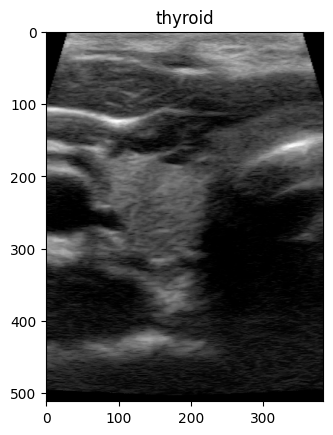

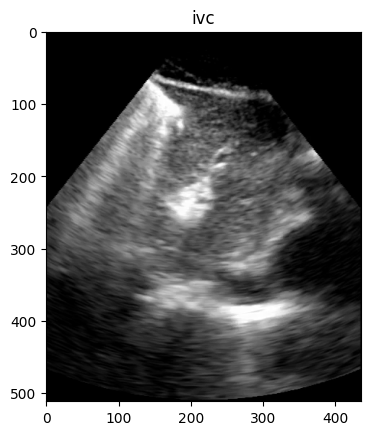

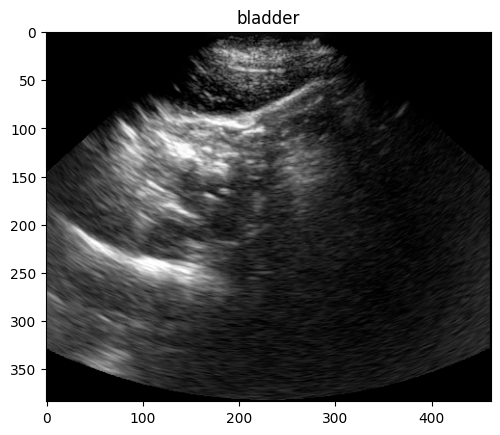

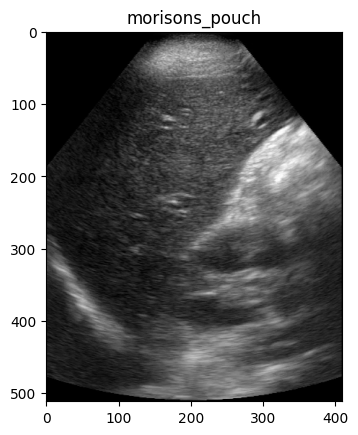

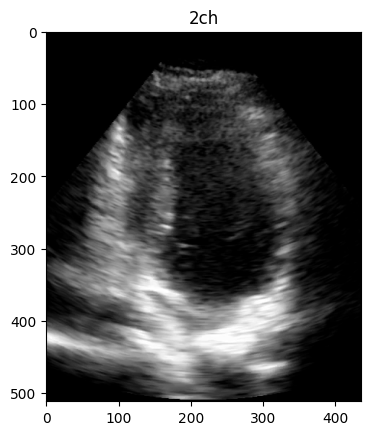

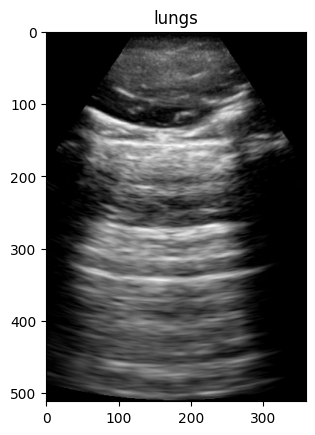

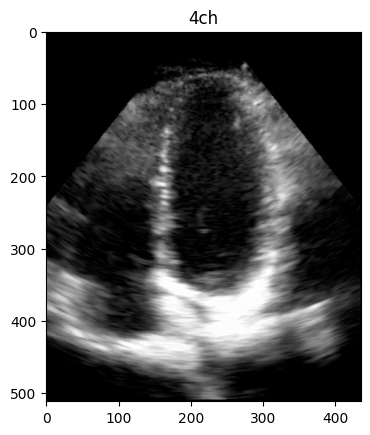

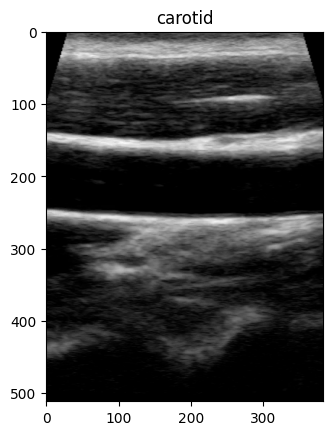

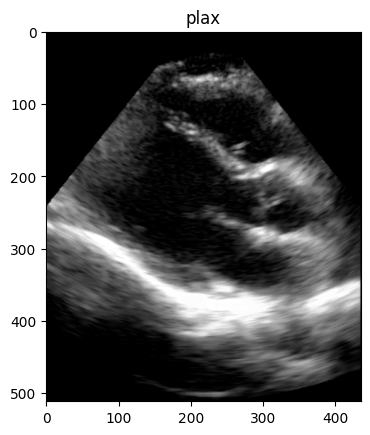

In [15]:
for label in labels:
    plt.imshow(df['Image'][(df['Label'] == label).idxmax()], cmap='gray')
    plt.title(label)
    plt.show()

In [16]:
df.groupby("Label")['Image'].apply(lambda x: np.unique(np.array(list(x.apply(lambda y: y.shape))), axis=0))

Label
2ch                           [[512, 436]]
4ch                           [[512, 436]]
bladder                       [[384, 462]]
carotid           [[512, 360], [512, 384]]
ivc               [[512, 384], [512, 436]]
lungs             [[512, 360], [512, 384]]
morisons_pouch                [[512, 410]]
plax                          [[512, 436]]
thyroid                       [[512, 384]]
Name: Image, dtype: object

Here are some observations based on the above data: 
1. Not all images are the same size
2. The scans look generally extremely distint. This should make it easy to identify with a low complexity model.

## Exploring Correlations

### Starting simple: means

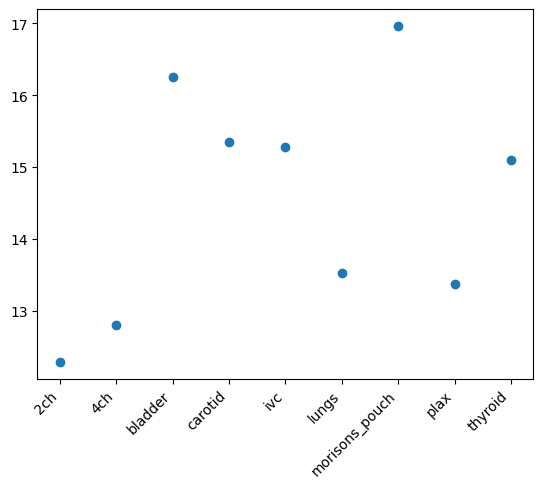

In [17]:
imageMean = np.vectorize(lambda image: np.mean(cv2.mean(image)[:3]))
df['Image_Mean'] = imageMean(df['Image'])
label_sorted_means = df.drop(['Image'], axis=1).groupby(['Label']).mean()
plt.scatter(label_sorted_means.index, label_sorted_means["Image_Mean"], label='Images')
plt.xticks(rotation=45, ha='right')
plt.show()
del(label_sorted_means)
del(imageMean)

This is a good start but it does not provide us with a ton of detail. Let's make some box plots instead

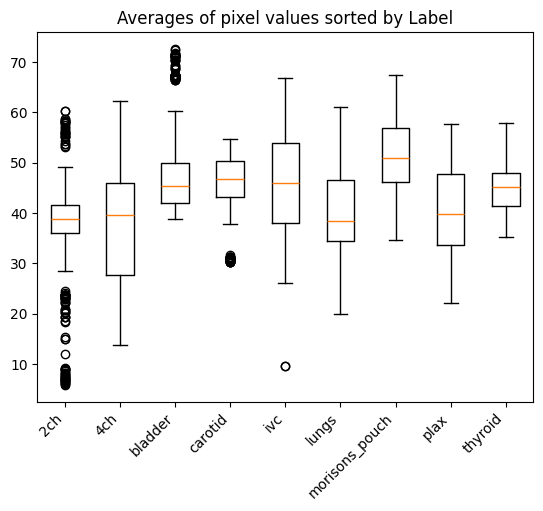

In [83]:
shaped_means = df.groupby("Label")['Image'].apply(lambda images: images.apply(lambda image: np.ndarray.flatten(image).mean()))
mean_matrix = [means[1] for means in shaped_means.groupby('Label')]
mean_labels = [means[0] for means in shaped_means.groupby('Label')]
plt.boxplot(mean_matrix, labels=mean_labels)
plt.xticks(rotation=45, ha='right')
plt.title("Averages of pixel values sorted by Label")
plt.show()
del(shaped_means, mean_labels, mean_matrix)

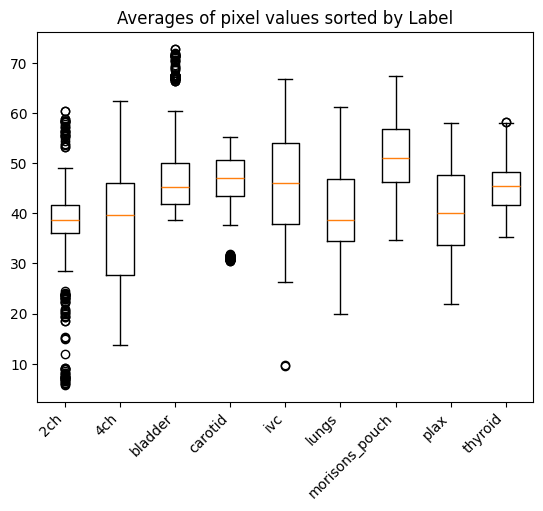

In [82]:
shaped_means = df.groupby("Label")['Image'].apply(lambda images: images.apply(lambda image: np.ndarray.flatten(cv2.resize(image, (64,64))).mean()))
mean_matrix = [means[1] for means in shaped_means.groupby('Label')]
mean_labels = [means[0] for means in shaped_means.groupby('Label')]
plt.boxplot(mean_matrix, labels=mean_labels)
plt.xticks(rotation=45, ha='right')
plt.title("Averages of pixel values sorted by Label")
plt.show()
del(shaped_means, mean_labels, mean_matrix)

Observations: Mean is not a good way to interpret the datas.As we can see there is a very large amount of variance in this metric so we would not be able to tell any of our photo apart with any kind of confidence

### Growing Complexity: Nieve Bayes

In [20]:
image_size = None

#### Training model

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
models = []
accuracies = []
pixel_range = range(1,70)

for length in pixel_range:
    image_size = (length, length)
    model = GaussianNB()
    df["Image Processed"] = [np.ndarray.flatten(cv2.resize(image, image_size)) for image in df['Image']]
    df_test["Image Processed"] = [np.ndarray.flatten(cv2.resize(image, image_size)) for image in df_test['Image']]
    model.fit(list(df['Image Processed']), list(df['Label']));
    predictions = model.predict(list(df_test['Image Processed']))
    accuracy = accuracy_score(predictions, df_test["Label"])
    models.append(model)
    accuracies.append(accuracy)

### The best model has 22 pixels and achives an accuraccy of 0.7111111111111111

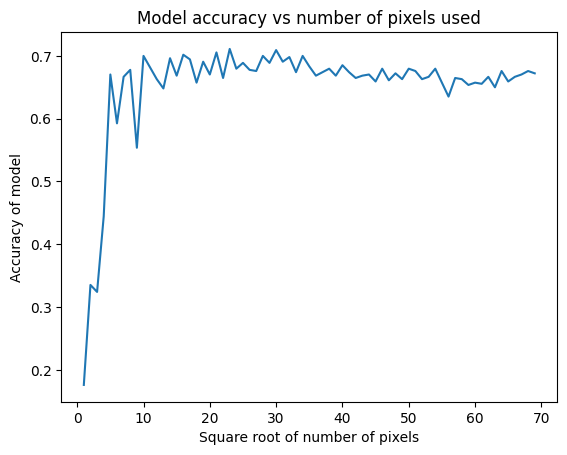

In [22]:
best = np.argmax(accuracies)
model = models[best]
image_size = (best+1, best+1)
df["Image Processed"] = [np.ndarray.flatten(cv2.resize(image, image_size)) for image in df['Image']]
df_test["Image Processed"] = [np.ndarray.flatten(cv2.resize(image, image_size)) for image in df_test['Image']]
plt.plot(pixel_range, accuracies)
plt.title("Model accuracy vs number of pixels used")
plt.xlabel("Square root of number of pixels")
plt.ylabel("Accuracy of model")
display(Markdown(f"### The best model has {best} pixels and achives an accuraccy of {accuracies[best]}"))

In [23]:
del(models)
del(accuracies)
del(pixel_range)

#### Checking Gaussian Assumptions
In order to make a gaussian naive bayes model we need to check an assumptiuon the model makes: **the data for any given feature of a specific label is *normally* distiributed**

With our dataset there is a problem: Many of the data points are black and irrelevant, expecially on the edges of the dataset because of the natural shape of an ultrasound scan. With that in mind we can only count features who have a mean above some value close to zero. 

Because we have 4096 features we cannot check these all manually. So instead we will use a shapiro-wilkes test for each of our features to check if the distibutions are normal. We will then report the number of distributions that pass this test, given an alpha of 95%

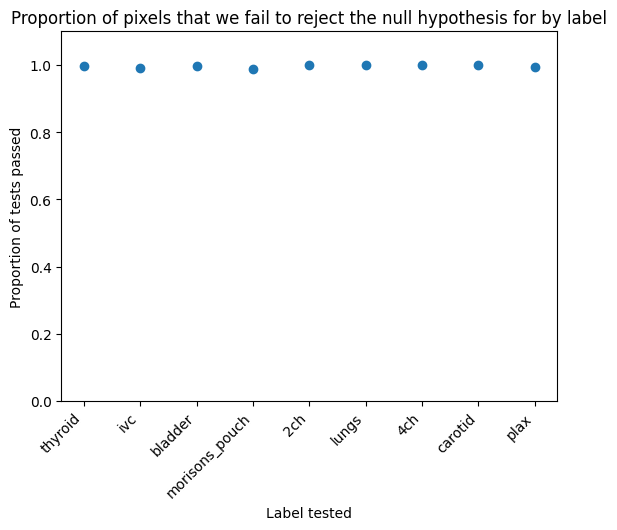

In [24]:
from scipy.stats import shapiro


label_proportions = []
for label in labels:
    df_filtered = np.array(list(df[df["Label"] == label]["Image Processed"]))
    shap_tests = []
    for pixel in range(np.prod(image_size)):
        if np.var(df_filtered[:,pixel]) > 0:
            shap_tests.append(shapiro(df_filtered[:,pixel]).pvalue < .05)
    label_proportions.append(np.mean(shap_tests))
plt.scatter(labels, label_proportions)
plt.xticks(rotation = 45, ha='right')
plt.title("Proportion of pixels that we fail to reject the null hypothesis for by label")
plt.xlabel("Label tested")
plt.ylabel("Proportion of tests passed")
plt.ylim(0,1.1)
plt.show()

#### Interpreting Model

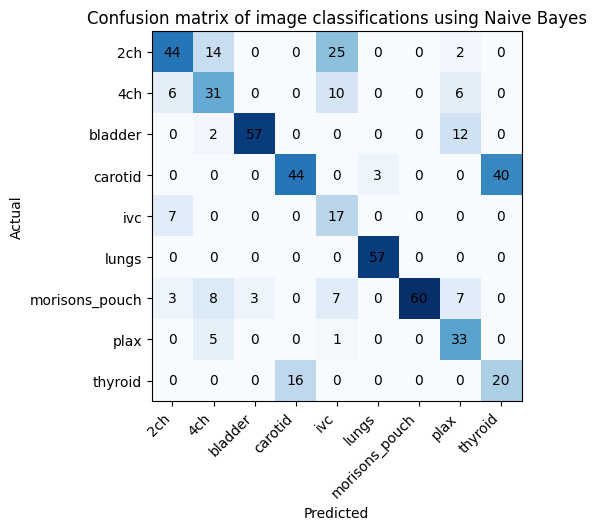

In [25]:
from cv2 import rotate
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predictions, df_test['Label'])

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

classes = np.unique(df_test["Label"])
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.title("Confusion matrix of image classifications using Naive Bayes")
plt.show()

**Observations**
1. IVC seems to be all over the place, although we don't mistake other loctions for ivc we seem to mistake IVC for other classes. If we look at the image printed out above we can detirmine this is because IVC has the least distict shapes to it's output. It has a very large range of means mening the images often vary and it is mostly white and very blurry. With the lack of distinctive features we are likely to be biased against choosing it. 

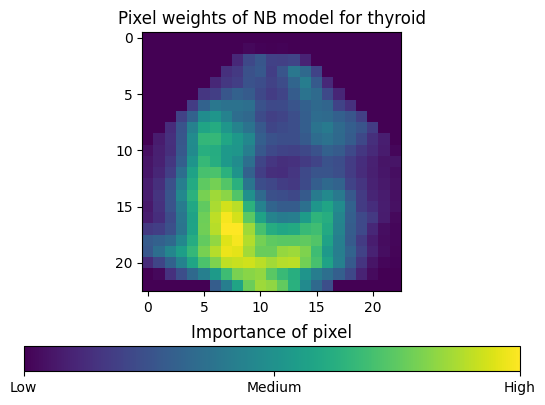

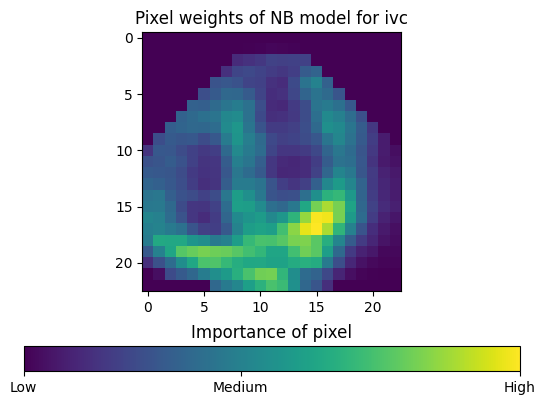

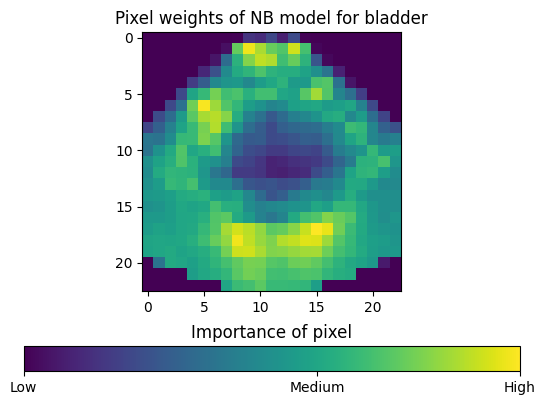

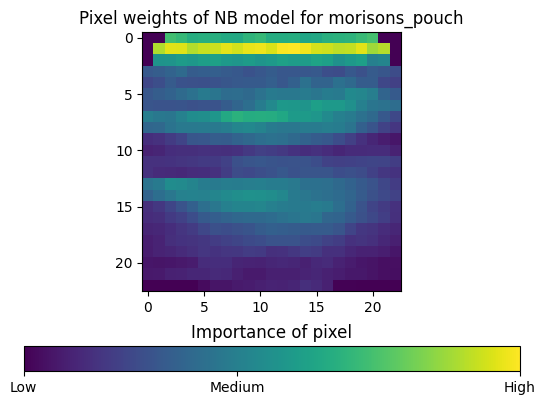

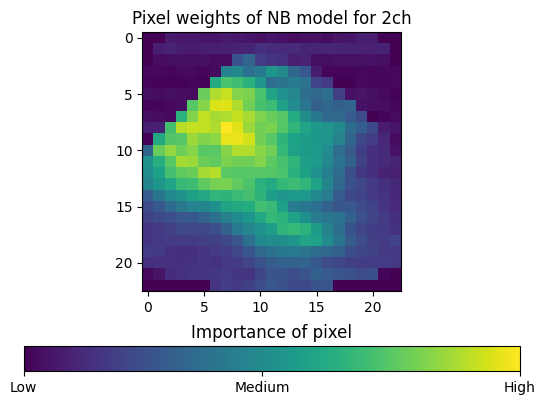

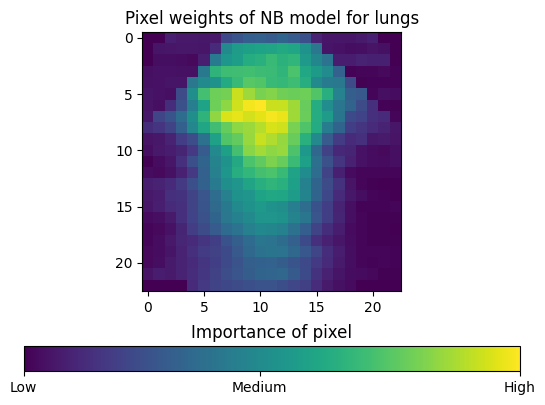

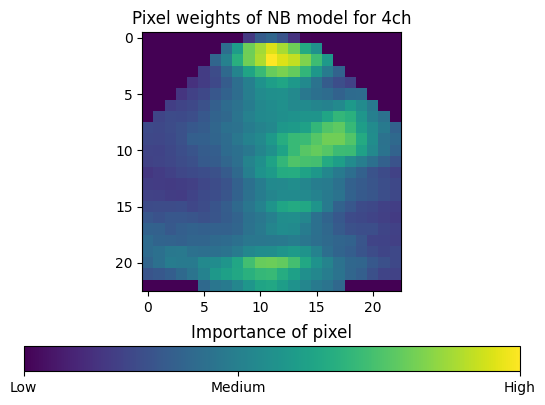

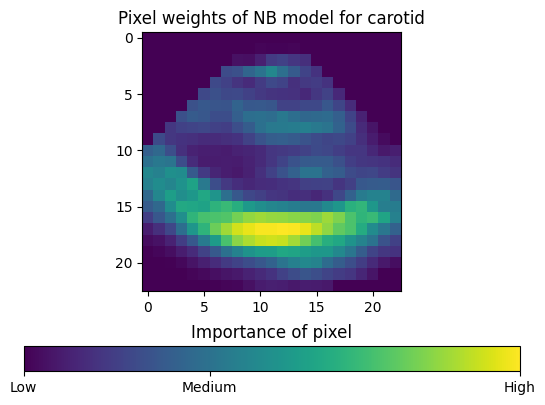

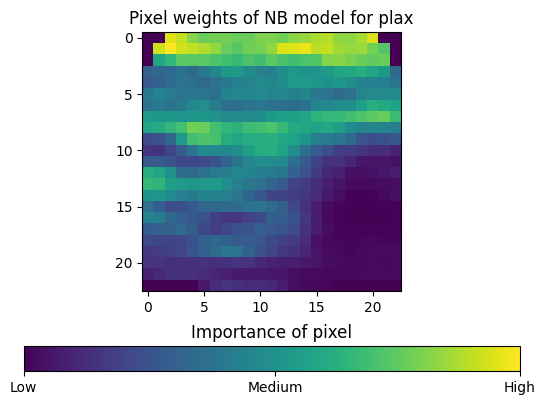

In [26]:
for i in range(9):
    label = labels[i]
    weights = model.theta_[i].reshape(image_size)
    plt.imshow(weights)
    cbar = plt.colorbar(ticks=[0,65,np.max(model.theta_[i])], orientation='horizontal')
    cbar.ax.set_title("Importance of pixel")
    cbar.ax.set_xticklabels(["Low", 'Medium', 'High'])
    plt.title(f"Pixel weights of NB model for {label}")
    plt.show()

This confirms my suspisions that ivc does not have any kind of remarkable characteristics. If we analize the graph for the models pixel importance we can see the boundaries are much more vauge. If this was a final project for a machine learning class I would dive deeper into investigating why this is. We will instead do a more statistical analysis of these results and the model.

#### Statistical Analysis of nieve bayes preprocessing

We will now use the preprocessing filters made by our nieve bayes to see if we can find a significant statistical difference in the model and the sum of the models values 

In [27]:
df_probs = model.predict_proba(list(df_test['Image Processed']))
df_probs = pd.DataFrame(df_probs, columns=model.classes_)
df_probs["Label"] = list(df_test['Label'])
df_probs.head()

,2ch,4ch,bladder,carotid,ivc,lungs,morisons_pouch,plax,thyroid,Label
0,0.0,0.000000e+00,0.0,0.0,4.886975e-69,0.0,1.000000e+00,0.000000e+00,0.0,2ch
1,0.0,0.000000e+00,0.0,0.0,3.974994e-48,0.0,1.000000e+00,7.453543e-132,0.0,2ch
2,0.0,0.000000e+00,0.0,0.0,1.000000e+00,0.0,2.462724e-88,0.000000e+00,0.0,2ch
3,0.0,0.000000e+00,0.0,0.0,1.000000e+00,0.0,2.442226e-122,0.000000e+00,0.0,2ch
4,0.0,2.766646e-280,0.0,0.0,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.0,2ch


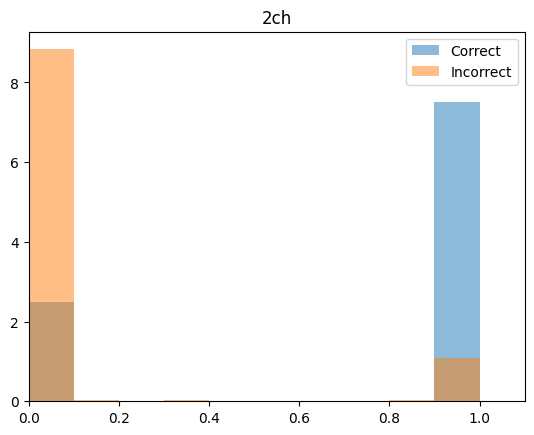

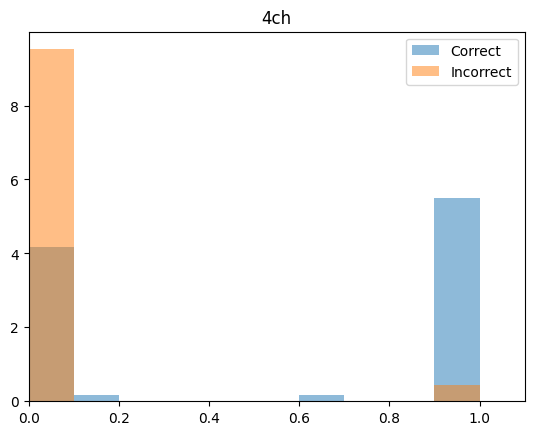

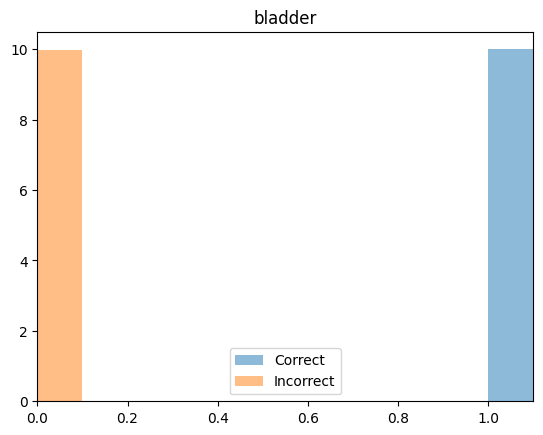

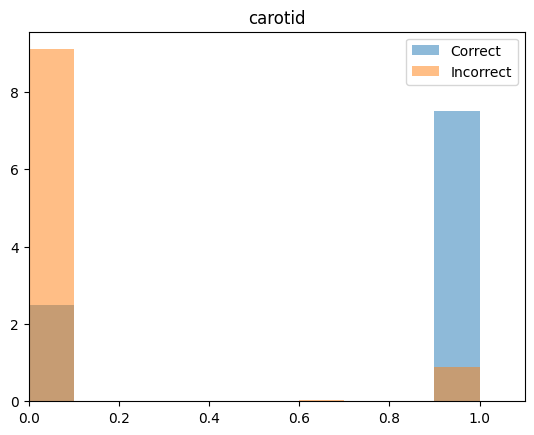

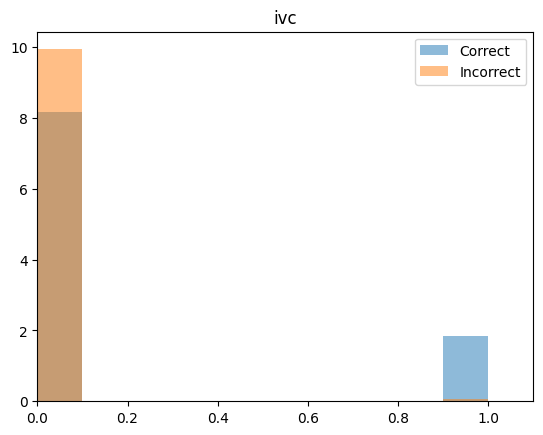

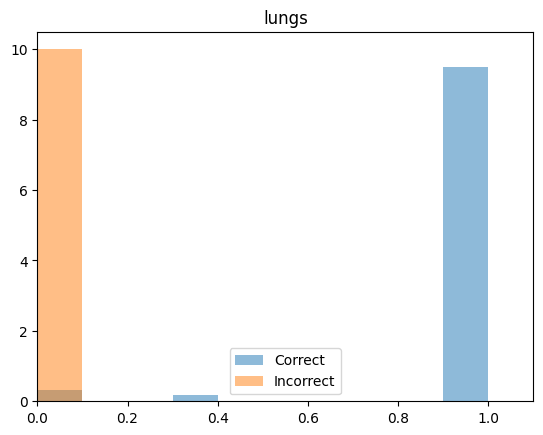

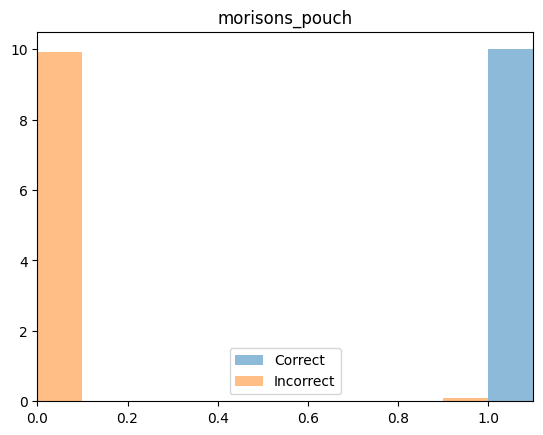

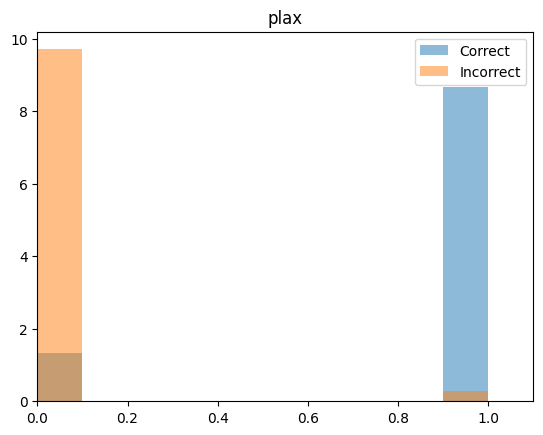

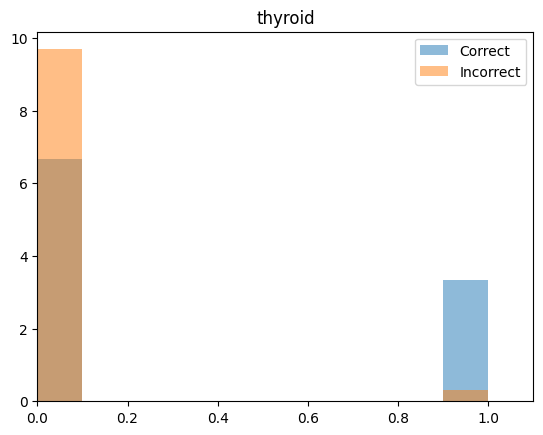

In [28]:
for label in model.classes_:
    label_locs = df_probs["Label"] == label
    plt.hist(df_probs.loc[label_locs][label], density=True, label="Correct", alpha=.5)
    plt.hist(df_probs.loc[np.logical_not(label_locs)][label], density=True, label="Incorrect", alpha=.5)
    plt.xlim(0,1.1)
    plt.title(label)
    plt.legend()
    plt.show()


So as it turns out the resulting probabiliities from the filter are extremely polarizing. We can still preform our t-test to find out if these distrubutions have statistically significant difference in means(spoiler: they do!!)

In [29]:
from scipy.stats import ttest_ind

t_test_by_label = []
for label in model.classes_:
    label_locs = df_probs["Label"] == label
    pos_samples = list(df_probs.loc[label_locs][label])
    neg_samples = list(df_probs.loc[np.logical_not(label_locs)][label])
    t_test_by_label.append(ttest_ind(pos_samples, neg_samples).pvalue)


/home/carter/.conda/envs/statsfinal/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


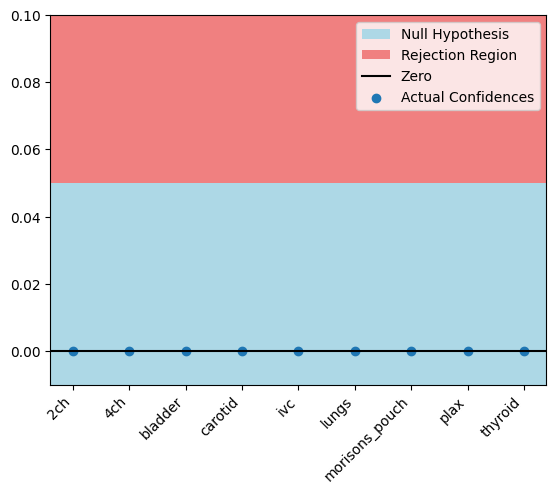

In [30]:
plt.axhspan(-.5,.05, facecolor = 'lightblue', label="Null Hypothesis")
plt.axhspan(.05,2, facecolor = 'lightcoral', label="Rejection Region")
plt.axhline(0, color='black', label='Zero')
plt.scatter(model.classes_, t_test_by_label, label="Actual Confidences")
plt.xticks(rotation = 45, ha = 'right')
plt.ylim(-.01,.1)
plt.legend()
plt.show()

# Conclusions

Yay! We have found a statistically significant way to differentiate our images. While this is not accuracte enough to use in medial work it is also a lightweight and fast model that uses very interpretable methods. It has been a great learning expirience! Hopefully I can apply something more sophisticated in the future to find a better way to label these images.